# Homework 2 - Machine Learning Pipeline
### Goal: To predict who will experience financial distress in the next two years.


### Read and Explore Data

In [1]:
% run util.py
% matplotlib inline

In [2]:
credit = read_file('data/credit-data.csv', 'csv', 'PersonID') 
data_dict = read_file('data/Data Dictionary.xls', 'excel')
d = create_data_dic(data_dict)
cdf = credit.copy() # making a copy of the original data in its unadulterated form

Thanks to Vidal, I discover a magical pandas library called pandas_profiling, which has a built-in function that runs summary statistics on ALL of your data.

In [3]:
#from pandas_profiling import ProfileReport

In [4]:
ProfileReport(cdf)

Number of variables,13
Number of observations,41016
Total Missing (%),1.7%
Total size in memory,4.1 MiB
Average record size in memory,104.0 B
Numeric,10
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,2


### Distribution of the Outcome Variable

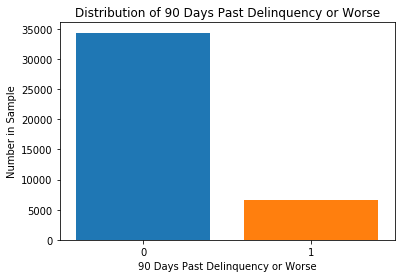

In [4]:
plot_hist(credit, 'SeriousDlqin2yrs', '90 Days Past Delinquency or Worse', sort=True)

### Correlation between Variables

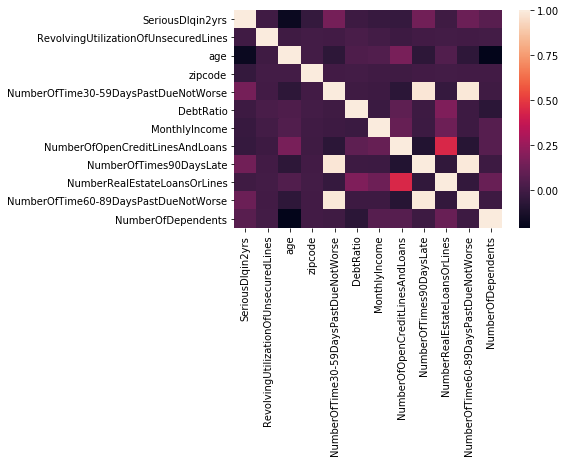

In [5]:
corr_matrix(credit)

The following 3 variables are HIGHLY correlated, something to keep in mind when selecting features.
- 'NumberOfTime30-59DaysPastDueNotWorse': Number Of Times Borrower Has Been 30-59 Days Past Due But No Worse In The Last 2 Years.
- 'NumberOfTime60-89DaysPastDueNotWorse': Number Of Times Borrower Has Been 60-89 Days Past Due But No Worse In The Last 2 Years.'
- 'NumberOfTimes90DaysLate': Number Of Times Borrower Has Been 90 Days Or More Past Due.

### Split Data into Train and Test Sets and Pre-Process Data
- We hold out 30% of the data as the validation set. To prevent data leakage, we split the data into train and test before we alter any data. 

In [6]:
ALL_COLS = [col for col in credit.columns if col != 'SeriousDlqin2yrs']

In [7]:
x_train, x_test, y_train, y_test = split_data(credit, predicted='SeriousDlqin2yrs', features=ALL_COLS, test_size=0.3)

Just checking manually that the ProfileReport was correct.

In [10]:
check_missing(x_train)

MonthlyIncome 5616
NumberOfDependents 738


Let's take a deeper look into those variables with missing values.

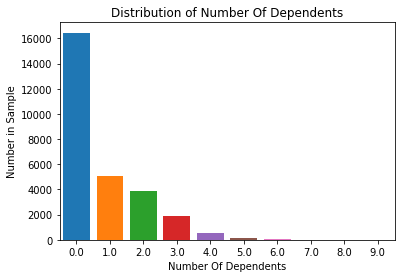

In [11]:
plot_hist(x_train, 'NumberOfDependents', 'Number Of Dependents', sort=True)

Since number of dependents are integer values, we will fill the null values with the median. We will also change the data type from float to integer.

In [12]:
impute_missing(x_train, 'NumberOfDependents', 'median')
x_train.NumberOfDependents = x_train.NumberOfDependents.astype(int)

In [13]:
x_train.NumberOfDependents.dtype

dtype('int64')

Because Income is highly skewed by extreme outliers, I impute the null values in monthly income using the median instead of the mean.

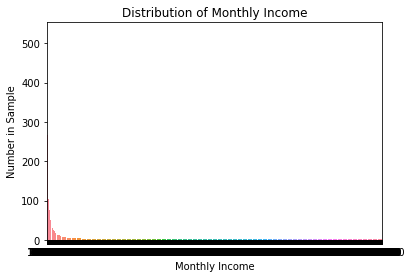

In [14]:
plot_hist(x_train, 'MonthlyIncome', 'Monthly Income', sort=True)

In [15]:
impute_missing(x_train, 'MonthlyIncome', 'median')

We also cap the monthly income with 99.9% quantile value as the maximum, which was $75,870 in this case.

In [16]:
cap_outlier(x_train, 'MonthlyIncome')

Monthly Income was capped at $75870.00000001353.


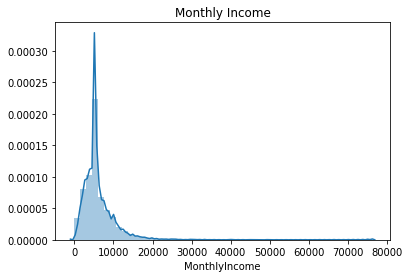

In [17]:
density_plot(x_train, 'MonthlyIncome', d)

We should have no more missing values.

In [18]:
check_missing(x_train)

We quickly do the same for the testing data.

In [19]:
check_missing(x_test)
impute_missing(x_test, 'NumberOfDependents', 'median')
x_test.NumberOfDependents = x_test.NumberOfDependents.astype(int)
impute_missing(x_test, 'MonthlyIncome', 'median')
cap_outlier(x_test, 'MonthlyIncome')

MonthlyIncome 2358
NumberOfDependents 299
Monthly Income was capped at $65353.6000000071.


### Discretize Variables
- Discretizing variables or creating dummy variables can be useful, especially when the relationship between the variable of interest and the outcome variable is not linear. Although we will not use the discretized columns for the KNN model in particular, we will test out the following functions that divide variables into equal sized buckets.
- For next time, I will create dummy variables, discrete bins using quantiles, and explore how that changes model interpretation.


We now discretize age into bins of 10.

In [20]:
x_train.age.describe()

count    28711.000000
mean        51.754066
std         14.792265
min         21.000000
25%         41.000000
50%         51.000000
75%         62.000000
max        109.000000
Name: age, dtype: float64

In [21]:
discretize_var(x_train, 'age', 10)

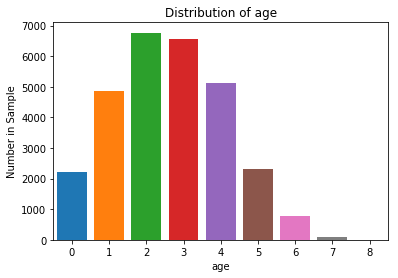

In [22]:
plot_hist(x_train, 'age_bin', 'age', sort=False)

And monthly income into bins of 2500.

In [23]:
discretize_var(x_train, 'MonthlyIncome', 2500)

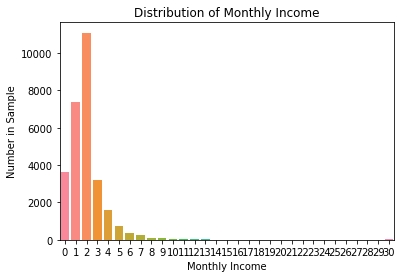

In [24]:
plot_hist(x_train, 'MonthlyIncome_bin', 'Monthly Income', sort=False)

We do the same for the training set.

In [25]:
discretize_var(x_test, 'age', 10)
discretize_var(x_test, 'MonthlyIncome', 2500)

### Model Selection
We vary k, distance metrics, p, weight function and select model with highest accuracy score on testing data.

As for features, we include all columns besides zip code, as zip code cannot have a numeric interpretation.

In [26]:
FEATURES = ['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
       'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
       'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']

In [27]:
x_train = select_features(x_train, features=FEATURES)
x_test = select_features(x_test, features=FEATURES)

In [29]:
top_model, eval_df = knn_models(x_train, y_train, x_test, y_test,
                                ks=[[1, 5, 10, 20, 50, 100], metric='minkowski', threshold=0.5)

Here is a sample of models evaluated.

In [30]:
eval_df.sample(5)

,k,metric,p,weight_fcn,accuracy_score
50,100,minkowski,1,uniform,0.833807
3,1,minkowski,4,uniform,0.759204
37,20,minkowski,3,distance,0.833482
51,100,minkowski,2,uniform,0.833726
48,50,minkowski,4,distance,0.835351


We have a top model!

In [31]:
top_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=1,
           weights='uniform')

Using the top model selected above (fit on training data, and evaluated on performance on testing data), we run the model again to get into the details of how the data is being classified.

### Model Performance on Training Data
We first look at the accuracy of the model on the data that we trained on. The accuracy score should be fairly high.

In [32]:
result_on_train = test_results(top_model, x_train, y_train, threshold=0.5)

In [33]:
validate(result_on_train.actual, result_on_train.predicted)

Accuracy Score: 0.8452509491135801


,predicted_no,predicted_yes
actual_no,24100,37
actual_yes,4406,168


### Model Performance on Testing Data
We then look at the accuracy of the model on the subset of the data that we held out to test the generalizability of the model. 

In [34]:
result_on_test = test_results(top_model, x_test, y_test, threshold=0.5)

In [35]:
result_on_test.filter(['actual', 'predicted']).head()

,actual,predicted
PersonID,,
147137,0,0
134590,0,0
120250,0,0
140037,1,0
39936,1,0


In [36]:
val = validate(result_on_test.actual, result_on_test.predicted)
val

Accuracy Score: 0.8355952864689151


,predicted_no,predicted_yes
actual_no,10237,22
actual_yes,2001,45


Now we can calculate the precision, recall, and F1 score (the harmonic mean of precision and recall) using the confusion matrix above.
- Precision: when our classifier classifies something as positive, how likely is it that the prediction is correct?
    - true positive / total classified positive 
- Recall: for all actual positive values, how likely is our predictor to predict it as True?
    - true positive / total actual positive

In [37]:
F1_score(val)

Precision: 0.6716417910447762 
Recall: 0.021994134897360705


0.04259346900141979

### Replicate using a higher threshold for classification to True.

Let's see what happens to our accuracy if we use a higher threshold, say 0.7.

In [38]:
top_model_7, eval_df_7 = knn_models(x_train, y_train, x_test, y_test,
                                    ks=[[1, 5, 10, 20, 50, 100], metric='minkowski', threshold=0.7)

In [39]:
eval_df_7.sample(5)

,k,metric,p,weight_fcn,accuracy_score
33,20,minkowski,4,uniform,0.834783
57,100,minkowski,3,distance,0.833807
30,20,minkowski,1,uniform,0.834295
47,50,minkowski,3,distance,0.834620
32,20,minkowski,3,uniform,0.834701


In [40]:
top_model_7

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=4,
           weights='distance')

In [41]:
result_7 = test_results(top_model_7, x_test, y_test, threshold=0.7)

In [42]:
validate(result_7.actual, result_7.predicted)

Accuracy Score: 0.8355952864689151


,predicted_no,predicted_yes
actual_no,10248,11
actual_yes,2012,34


The precision goes up, while the recall goes down. This result is expected, as we are reducing the number of false positives at the risk of increasing the number of false negatives.

In [43]:
F1_score(validate(result_7.actual, result_7.predicted))

Accuracy Score: 0.8355952864689151
Precision: 0.7555555555555555 
Recall: 0.016617790811339198


0.032520325203252029

We quickly check the results of that same model if the threshold is reduced to 0.3. We should expect the precision to decrease, while the recall would increase.

In [47]:
result9 = test_results(top_model_7, x_test, y_test, threshold=0.3)

In [48]:
validate(result9.actual, result9.predicted)

Accuracy Score: 0.7622104835432751


,predicted_no,predicted_yes
actual_no,8918,1341
actual_yes,1585,461


In [49]:
F1_score(validate(result9.actual, result9.predicted))

Accuracy Score: 0.7622104835432751
Precision: 0.255826859045505 
Recall: 0.22531769305962854


0.2396049896049896